<a href="https://colab.research.google.com/github/aditya-shriwastava/colab-notebooks/blob/master/visual_odometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip3 install

In [125]:
!pip3 install scikit-image

# import

In [126]:
import os

import numpy as np

import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import ransac

# Load kitti dataset

In [3]:
if "2011_09_26_drive_0020_sync.zip" not in os.listdir():
  !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0020/2011_09_26_drive_0020_sync.zip
  !unzip  2011_09_26_drive_0020_sync.zip >/dev/null

dataset_dir = "./2011_09_26/2011_09_26_drive_0020_sync/image_02"
imgs_dir = os.path.join(dataset_dir, "data")
timestamps_file_path = os.path.join(dataset_dir, "timestamps.txt")

imgs_file_name = os.listdir(imgs_dir)
imgs_file_name.sort()

imgs_file_path = [os.path.join(imgs_dir, img_file_name) for img_file_name in imgs_file_name]
kitti_imgs = np.array([cv2.imread(img_file_path) for img_file_path in imgs_file_path])

--2021-12-29 03:41:58--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0020/2011_09_26_drive_0020_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.75.227
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.75.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367093728 (350M) [application/zip]
Saving to: ‘2011_09_26_drive_0020_sync.zip’

2011_09_26_drive_00 100%[===================>] 350.09M  20.4MB/s    in 19s     

2021-12-29 03:42:17 (18.3 MB/s) - ‘2011_09_26_drive_0020_sync.zip’ saved [367093728/367093728]



# Disp utils

In [109]:
def disp(img_tn1, kps_tn1, kps_t):
  disp_img = img_tn1.copy()
  for kp_tn1, kp_t in zip(kps_tn1, kps_t):
    start_point = tuple(kp_tn1)
    end_point = tuple(kp_t)
    disp_img = cv2.circle(disp_img, start_point, 2, (0, 0, 255), 2)
    disp_img = cv2.line(disp_img, start_point, end_point, (0, 0, 255), 1)
  cv2_imshow(disp_img)

# FundamentalMatrixTransform

In [112]:
class FundamentalMatrixTransform():
  def __init__(self):
    self.F = np.eye(3)

  def estimate(self, kps_tn1, kps_t):
    # Setup constraint matrix
    A = np.column_stack((
      kps_tn1[:,0] * kps_t[:,0],
      kps_tn1[:,0] * kps_t[:,1],
      kps_tn1[:,0],
      kps_tn1[:,1] * kps_t[:,0],
      kps_tn1[:,1] * kps_t[:,1],
      kps_tn1[:,1],
      kps_t[:,0],
      kps_t[:,1],
      np.ones(len(kps_tn1)),
    ))

    # Solve for nullsapce of the constraint matrix
    u, s, vt = np.linalg.svd(A)
    F = vt[-1,:].reshape(3,3)

    # Enforcing Rank 2
    u, s, vt = np.linalg.svd(F)
    s[2] = 0
    self.F = u @ np.diag(s) @ vt

    return True

  def residuals(self, kps_tn1, kps_t):
    # point-to-epipolar line distance
    # suffix underscore indicate homogeneous coordimate
    kps_tn1_ = np.column_stack([kps_tn1, np.ones(kps_tn1.shape[0])])
    kps_t_ = np.column_stack([kps_t, np.ones(kps_t.shape[0])])

    e_tn1 = kps_t_ @ self.F.T  # Epipilar line on tn1 image
    e_t = kps_tn1_ @ self.F  # Epipilar line on t image
    
    residue = (kps_tn1_ * e_tn1).sum(axis = 1) # Residue from coplanarity constraint

    return np.abs(residue) / np.sqrt(e_tn1[:,0]**2 + e_tn1[:,1]**2
                                     + e_t[:,0]**2 + e_t[:,1]**2)

## Test

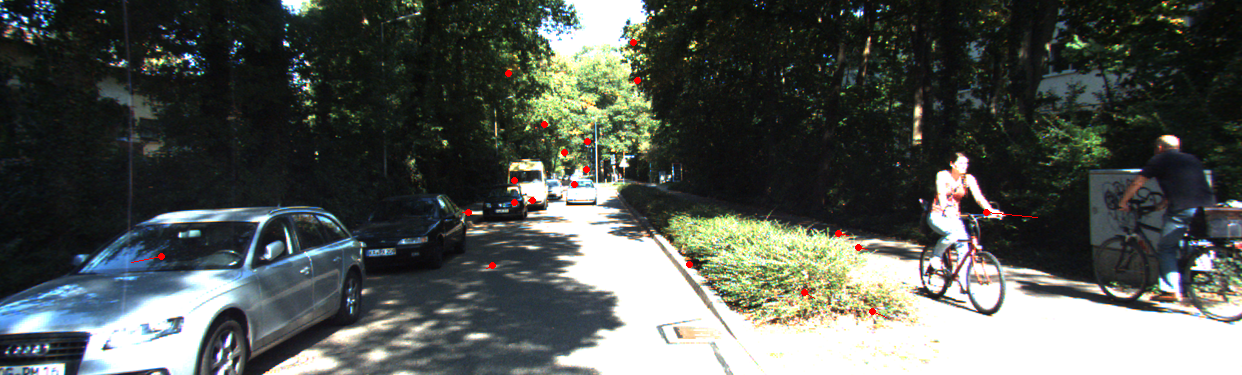

Fundamental Matrix: [[-1.17664368e-06 -2.81891581e-04  4.70289552e-02]
 [ 2.77459065e-04 -8.07524563e-07 -1.77481406e-01]
 [-4.48496765e-02  1.80770080e-01 -9.65193844e-01]]
Residuals for corresponding points:
[0.37130621 1.20965691 0.18079432 0.86765648 0.45992559 0.22238851
 0.40008999 0.22983077 0.3850392  0.22364134 0.55982321 0.60125545
 0.67377815 0.03606049 0.12180513 0.00393741 0.54630653 0.11318071
 0.29818723 0.00961099]
Residuals for random points:
[ 96.65300268  29.24251551  70.71178186  15.32708934  34.37683639
 112.39976262  36.61017565  71.92325287  17.42831854  25.70436316
 109.57575787  36.52264525  31.69134826  32.55619711  19.89418458
  73.07903351   0.54630653   0.11318071  10.79723648   8.54641695]


In [111]:
img_tn1 = kitti_imgs[0]
img_t = kitti_imgs[1]

# Ground truth corresponding Keypoints in img_tn1 and img_t
kps_tn1 = np.array([[838,233],[508,73],[514,180],[468,212],[587,141],[492,265],[986,212],[633, 42],[872,311],[544,124],
                    [804,292],[858,247],[689,264],[161,256],[574,184],[637,80],[532,200],[514,202],[564,152],[586,169]])

kps_t = np.array([[ 848,235],[506,72],[512,180],[462,212],[587,141],[486,268],[1037,217],[632,39],[886,317],[542,124],
                  [814,298],[867,249],[690,267],[131,262],[572,184],[636,79],[528,200],[512,202],[564,152],[585,169]])

disp(img_tn1, kps_tn1, kps_t)

F = FundamentalMatrixTransform()
F.estimate(kps_tn1, kps_t)

print(f"Fundamental Matrix: {F.F}")

print("Residuals for corresponding points:")
print(F.residuals(kps_tn1, kps_t))

print("Residuals for random points:")
permutation = np.random.choice(range(20), replace=False, size=20)
print(F.residuals(kps_tn1, kps_t[permutation]))

# Features utils

In [122]:
def extract_features(img):
  """
  Args
    img: numpy array of shape (H,W,C) representing image
  Returns
    kps: numpy array of shape (N, 2) representing coordinates of N
      keypoints detected
    des: numpy array of shape (N, 32) representing 32 dim descriptor
      of N keypoints
  """
  img = np.expand_dims(np.mean(img, axis=2).astype(np.uint8), -1)
  orb = cv2.ORB_create(nfeatures=5000)
  kps, des = orb.detectAndCompute(img, None)
  kps = np.array([[kp.pt[0], kp.pt[1]] for kp in kps]).astype(np.int32)
  return kps, des


def match_features(des_tn1, des_t):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = bf_matcher.match(des_tn1, des_t)
  return np.array([[match.queryIdx, match.trainIdx] for match in matches])

def match_features2(des_tn1, des_t):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
  matches = bf_matcher.knnMatch(des_tn1, des_t, k=2)

  idx_tn1, idx_t = [], []
  for m1, m2 in matches:
    # Lowe's ratio test
    if m1.distance <= 1 * m2.distance:
      if m1.distance < 32:
        if m1.trainIdx not in idx_t:
          idx_tn1.append(m1.queryIdx)
          idx_t.append(m1.trainIdx)

  assert len(idx_tn1) >= 8, f"#matches: {len(idx_tn1)}" 
  return np.array([idx_tn1, idx_t]).T

# Main

#kps_tn1: 4947 #kps_t: 4933
Before RANSAC
#matches: 1858


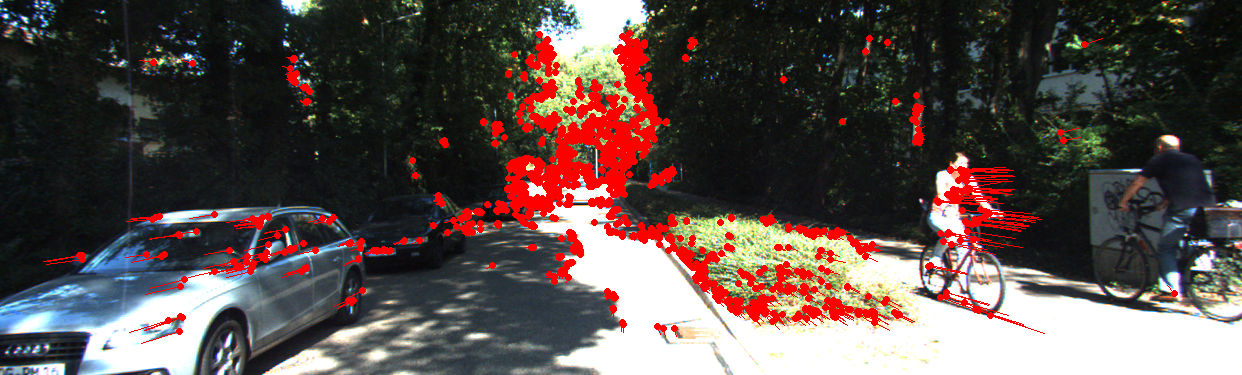

After RANSAC
#matches: 1514


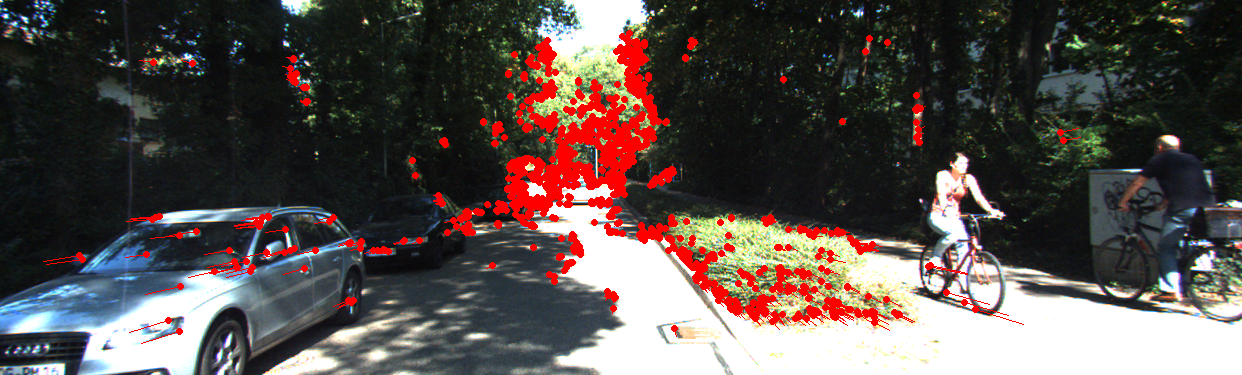

In [127]:
img_tn1 = kitti_imgs[0]
img_t = kitti_imgs[1]

kps_tn1, des_tn1 = extract_features(img_tn1)
kps_t, des_t = extract_features(img_t)
print(f"#kps_tn1: {len(kps_tn1)} #kps_t: {len(kps_t)}")

print("Before RANSAC")
matches = match_features2(des_tn1, des_t)
print(f"#matches: {len(matches)}")
disp(img_tn1, kps_tn1[matches[:,0]], kps_t[matches[:,1]])

F, inliers = ransac(
  (kps_tn1[matches[:,0]], kps_t[matches[:,1]]),
  FundamentalMatrixTransform,
  min_samples=8,
  residual_threshold=1,
  max_trials=100
)

print("After RANSAC")
matches = matches[inliers]
print(f"#matches: {len(matches)}")
disp(img_tn1, kps_tn1[matches[:,0]], kps_t[matches[:,1]])